In [1]:
import pandas as pd
!pip install shapely

DEPRECATION: pandas 0.23.4 has a non-standard dependency specifier pytz>=2011k. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pandas or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: unyt 2.8.0 has a non-standard dependency specifier numpy>="1.13.0". pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of unyt or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [5]:
%run ROUTINES/gauss_asym.py

In [6]:
%matplotlib widget

## Load fit info

In [8]:
#df_fits = pd.read_csv('fit_info/fit_sobrevivientes_rho_arm2.csv')
id_halo='17'
df_fits = pd.read_csv(f'FIT_INFO/fit_params_rho_arm1_adicionales_HALO{id_halo}_.csv')
df_fits['x'] = df_fits.apply(lambda row: convert_from_listAsAString_to_listOfFloats(row.x), axis = 1)
df_fits['y'] = df_fits.apply(lambda row: convert_from_listAsAString_to_listOfFloats(row.y), axis = 1)

In [9]:
df_fits.tail(3)

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing
0,0.000011,4.879365,0.05,False,0.686374,14.0,0.393644,0.000001,0.889328,4.443072,0.49581,"[4.298750736065823, 4.480197704769558, 4.59564...",-4.902597,"[2.877623224295711e-06, 4.410360268359912e-06,...",-0.813312


In [10]:
params = df_fits.iloc[0] # Para investigar los resultado del fit de un punto, llamamos su fila en el DataFrame

In [11]:
params

amplitude                                                 1.13657e-05
center                                                        4.87937
delta                                                            0.05
fractured                                                       False
gamma                                                        0.686374
id_tracing                                                         14
sigma                                                        0.393644
stderr_amplitude                                          1.36373e-06
stderr_center                                                0.889328
stderr_gamma                                                  4.44307
stderr_sigma                                                  0.49581
x                   [4.298750736065823, 4.480197704769558, 4.59564...
x_tracing                                                     -4.9026
y                   [2.877623224295711e-06, 4.410360268359912e-06,...
y_tracing           

In [12]:
#import numpy as np

# Convertir las columnas 'x' y 'y' de cadenas a arrays numéricos
#params['x'] = np.array(params['x'].split('\\n'), dtype=float)
#params['y'] = np.array(params['y'].split('\\n'), dtype=float)

# Verificar los resultados
#print("X values:", params['x'])
#print("Y values:", params['y'])


In [13]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False


In [14]:
from shapely.geometry import LineString

def find_widths_of_skewed_gaussian_dani(params, dx=0.001):
    # Evaluar el modelo ajustado
    fitted_model = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = fitted_model['x_eval']
    y_eval = fitted_model['y_eval']

    # Encuentra el máximo
    x_max, y_max = find_maximum(x_eval, y_eval)

    # Generar la línea horizontal en y = y_max / 2
    xs_line = np.arange(np.min(x_eval), np.max(x_eval), 0.01)
    ys_line = np.full(len(xs_line), 0.5 * y_max)

    # Crear LineString para las dos líneas
    first_line = LineString(np.column_stack((x_eval, y_eval)))
    second_line = LineString(np.column_stack((xs_line, ys_line)))
    intersection = first_line.intersection(second_line)

    points_intercept = []

    # Si la intersección es un solo punto
    if intersection.geom_type == 'Point':
        points_intercept = [(intersection.x, intersection.y)]
    # Si la intersección es una colección de puntos
    elif hasattr(intersection, 'geoms'):
        points_intercept = [(point.x, point.y) for point in intersection.geoms]
    # Si no hay intersección
    elif intersection.is_empty:
        return {'x_max': x_max, 'y_max': y_max, 'w1': np.nan, 'w2': np.nan}

    # Asegurarse de que hay suficientes puntos de intersección
    if len(points_intercept) >= 2:
        w1 = x_max - points_intercept[1][0]
        w2 = points_intercept[0][0] - x_max
    else:
        w1, w2 = np.nan, np.nan  # Si no hay suficientes intersecciones

    return {'x_max': x_max, 'y_max': y_max, 'w1': w1, 'w2': w2}

def plot_fit_and_widths_dani(params, ax, dx=0.001):
    width_info = find_widths_of_skewed_gaussian_dani(params, dx=dx)

    dict_eval = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = dict_eval['x_eval']
    y_eval = dict_eval['y_eval']

    # Plotea la función ajustada
    ax.plot(x_eval, y_eval, lw=2.5, label='Fitted Function')

    # Máximos y anchos
    ax.axvline(x=width_info['x_max'], color='red', lw=1.5, label='x_max = {:.3f}'.format(width_info['x_max']))
    ax.axhline(y=width_info['y_max'], ls='--', color='k', label='y_max = {:.2e}'.format(width_info['y_max']))
    ax.axhline(y=0.5 * width_info['y_max'], color='green', lw=1.5, label='y_max / 2 = {:.2e}'.format(0.5 * width_info['y_max']))

    # Líneas verticales para w1 y w2
    ax.axvline(x=np.abs(width_info['x_max'] - width_info['w1']), color='magenta', lw=1.5, ls='--', label='w1 = {:.3f}'.format(width_info['w1']))
    ax.axvline(x=np.abs(width_info['x_max'] + width_info['w2']), color='purple', lw=1.5, ls='--', label='w2 = {:.3f}'.format(width_info['w2']))

    # Ajustar etiquetas de los ticks
    xt = ax.get_xticks()
    tick1 = '{:.2f}'.format(np.abs(width_info['x_max'] - width_info['w1']))
    tick2 = '{:.2f}'.format(np.abs(width_info['x_max'] + width_info['w2']))
    xt = np.append(xt, [float(tick1), float(tick2)])

    ax.set_xticks(xt)
    ax.set_xticklabels(xt)

    ax.grid(alpha=0.5, lw=1, ls='--')
    ax.legend(loc='upper left')



In [15]:
params['x']

[4.298750736065823,
 4.480197704769558,
 4.595641102659986,
 4.626711406630787,
 4.695825686772351,
 4.726516453617603,
 4.783991146206907,
 4.831536720727768,
 4.891709531251387,
 4.927783004590375,
 4.99639907392481,
 5.046018519909557,
 5.096894050089259,
 5.141744518621398,
 5.198349486370291,
 5.234137359813754,
 5.281849701605776,
 5.3062249448493,
 5.380328171646238,
 5.433253583718268,
 5.495549161831466]

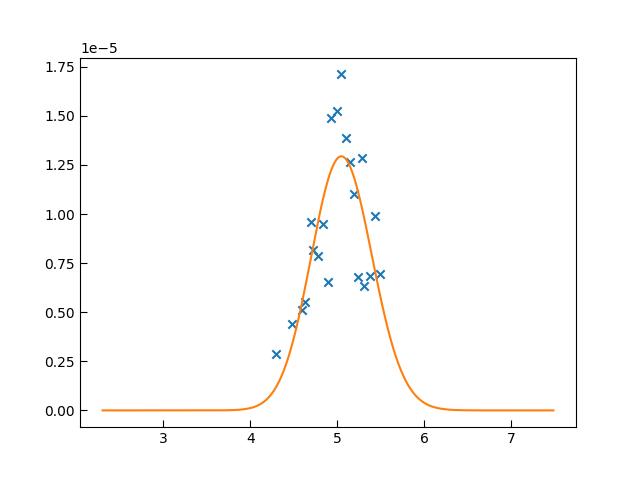

In [16]:

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

# Graficamos el fit y los puntos con los que se hizo el fit
fig, ax = plt.subplots()
ax.scatter(params.x, params.y, color = 'C0', marker = 'x') # Envoltorio
model_eval = eval_fitted_model_with_given_params(params, dx = 0.01) # Funcion en gauss_asym.py
x_eval = model_eval['x_eval']
y_eval = model_eval['y_eval']
ax.plot(x_eval, y_eval,color = 'C1'); # Fit

## Calculate width of a fit

In [17]:
%run ROUTINES/gauss_asym.py

In [18]:
dx = 0.001 # Discretizacion para mapear la gaussiana

In [19]:
width_info = find_widths_of_skewed_gaussian_dani(params, dx = dx) # Funcion en gauss_asym.py

In [20]:
width_info # Retorna la ubicacion del maximo (x_max, y_max) y el ancho a la izquierda (w1) y a la derecha (w2)

{'x_max': 5.04675073606552,
 'y_max': 1.2939163502216605e-05,
 'w1': 0.4070495618020171,
 'w2': 0.41721007411450817}

In [21]:
#fig, ax = plt.subplots(figsize=(10,5))
#plot_fit_and_widths(params, ax, dx = dx) # Funcion en gauss_asym.py

In [22]:
# Podemos aplicar find_widths_of_skewed_gaussian() a toda la tabla con la informacion de los parametros 

df_fits['width_info'] = df_fits.apply(lambda row: find_widths_of_skewed_gaussian_dani(row), axis = 1)
df_fits['x_max'] = df_fits.apply(lambda row: row.width_info['x_max'], axis = 1)
df_fits['y_max'] = df_fits.apply(lambda row: row.width_info['y_max'], axis = 1)
df_fits['w1'] = df_fits.apply(lambda row: row.width_info['w1'], axis = 1)
df_fits['w2'] = df_fits.apply(lambda row: row.width_info['w2'], axis = 1)

In [23]:


df_fits.head(10)

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing,width_info,x_max,y_max,w1,w2
0,0.000011,4.879365,0.05,False,0.686374,14.0,0.393644,0.000001,0.889328,4.443072,0.49581,"[4.298750736065823, 4.480197704769558, 4.59564...",-4.902597,"[2.877623224295711e-06, 4.410360268359912e-06,...",-0.813312,"{'x_max': 5.04675073606552, 'y_max': 1.2939163...",5.046751,0.000013,0.40705,0.41721


In [24]:
df_fits

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing,width_info,x_max,y_max,w1,w2
0,0.000011,4.879365,0.05,False,0.686374,14.0,0.393644,0.000001,0.889328,4.443072,0.49581,"[4.298750736065823, 4.480197704769558, 4.59564...",-4.902597,"[2.877623224295711e-06, 4.410360268359912e-06,...",-0.813312,"{'x_max': 5.04675073606552, 'y_max': 1.2939163...",5.046751,0.000013,0.40705,0.41721


## Results

In [26]:
df_tracing_arm1 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm1_rho_dani.csv')
df_tracing_arm1['arm'] = [1]*len(df_tracing_arm1)
df_tracing_arm1['id'] = np.arange(0,len(df_tracing_arm1),1)

df_tracing_arm2 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm2_rho_dani.csv')
df_tracing_arm2['arm'] = [2]*len(df_tracing_arm2)
df_tracing_arm2['id'] = np.arange(0,len(df_tracing_arm2),1)

df_arms = pd.concat([df_tracing_arm1,df_tracing_arm2], axis = 0).reset_index(drop=True)

In [27]:
df_arms

,x,y,arm,id
0,12.707792,14.355519,1,0
1,10.993506,14.459416,1,1
2,7.668831,14.407468,1,2
3,2.006494,12.952922,1,3
4,1.175325,12.069805,1,4
5,-0.279221,10.926948,1,5
6,-1.941558,9.680195,1,6
7,-2.512987,8.537338,1,7
8,-2.928571,7.082792,1,8
9,-3.551948,6.095779,1,9


In [30]:
Df_fits = pd.concat(dfs, axis = 0).reset_index(drop=True)
df_fits['r_tracing'] = np.sqrt(df_fits['x_tracing']**2 + df_fits['y_tracing']**2)
df_fits['width_info'] = df_fits.apply(lambda row: find_widths_of_skewed_gaussian_dani(row), axis = 1)
df_fits['x_max'] = df_fits.apply(lambda row: row.width_info['x_max'], axis = 1)
df_fits['y_max'] = df_fits.apply(lambda row: row.width_info['y_max'], axis = 1)
df_fits['w1'] = df_fits.apply(lambda row: row.width_info['w1'], axis = 1)
df_fits['w2'] = df_fits.apply(lambda row: row.width_info['w2'], axis = 1)

ValueError: No objects to concatenate

In [54]:
 df_fits

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing,arm,r_tracing
0,0.000053,3.999801,0.05,False,8.627322,11.0,0.567687,0.000003,0.010485,2.699845,0.040324,[],4.062040,[],-0.727385,1,4.126652
1,0.000069,6.262372,0.05,False,-6.766237,10.0,0.838236,0.000003,0.012504,1.430586,0.047692,[],4.705896,[],3.687626,2,5.978632


In [50]:
import re

def convert_from_listAsAString_to_listOfFloats(string):
    # Limpia el string para eliminar cualquier caracter no numérico válido.
    string_clean = re.sub(r'[^\d.\n-]', '', string)  # Elimina todo excepto dígitos, puntos decimales, saltos de línea y guiones.
    
    # Divide la cadena en líneas y convierte a flotantes, filtrando los valores inválidos.
    splitted = string_clean.strip().split('\\n')
    listOfFloats = []
    for s in splitted:
        try:
            listOfFloats.append(float(s))
        except ValueError:
            print(f"Warning: '{s}' no es un valor flotante válido y fue ignorado.")
    return listOfFloats

# Aplicar la función en las columnas 'x' y 'y'
dfs = []
for i, arm in enumerate(['arm1', 'arm2']):
    df_fits = pd.read_csv('fit_info/fit_params_rho_{}_adicionales_dani.csv'.format(arm))
    
    # Aplicar la limpieza y conversión en las columnas 'x' y 'y'
    df_fits['x'] = df_fits.apply(lambda row: convert_from_listAsAString_to_listOfFloats(row.x), axis=1)
    df_fits['y'] = df_fits.apply(lambda row: convert_from_listAsAString_to_listOfFloats(row.y), axis=1)
    
    # Añadir la columna 'arm'
    df_fits['arm'] = [i+1] * len(df_fits)
    
    dfs.append(df_fits)



In [51]:
def find_widths_of_skewed_gaussian_dani(params, dx=0.001):
    # Evaluar el modelo ajustado
    fitted_model = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = fitted_model['x_eval']
    y_eval = fitted_model['y_eval']

    # Verificar que x_eval y y_eval no estén vacíos
    if len(x_eval) == 0 or len(y_eval) == 0:
        print(f"Advertencia: 'x_eval' o 'y_eval' están vacíos para params id: {params.get('id_tracing', 'desconocido')}")
        return {'x_max': np.nan, 'y_max': np.nan, 'w1': np.nan, 'w2': np.nan}

    # Continúa si no están vacíos
    x_max, y_max = find_maximum(x_eval, y_eval)

    xs_line = np.arange(np.min(x_eval), np.max(x_eval), 0.01)
    ys_line = np.full(len(xs_line), 0.5 * y_max)

    first_line = LineString(np.column_stack((x_eval, y_eval)))
    second_line = LineString(np.column_stack((xs_line, ys_line)))
    intersection = first_line.intersection(second_line)

    points_intercept = []
    if isinstance(intersection, MultiPoint):
        points_intercept = list(intersection)
    elif not intersection.is_empty:
        points_intercept = [intersection]

    points_intercept = [[point.x, point.y] for point in points_intercept]

    if len(points_intercept) >= 2:
        w1 = x_max - points_intercept[1][0]
        w2 = points_intercept[0][0] - x_max
    else:
        w1, w2 = np.nan, np.nan  # Si no hay suficientes intersecciones

    return {'x_max': x_max, 'y_max': y_max, 'w1': w1, 'w2': w2}



df_fits = pd.concat(dfs, axis = 0).reset_index(drop=True)
df_fits['r_tracing'] = np.sqrt(df_fits['x_tracing']**2 + df_fits['y_tracing']**2)
df_fits['width_info'] = df_fits.apply(lambda row: find_widths_of_skewed_gaussian_dani(row), axis = 1)
df_fits['x_max'] = df_fits.apply(lambda row: row.width_info['x_max'], axis = 1)
df_fits['y_max'] = df_fits.apply(lambda row: row.width_info['y_max'], axis = 1)
df_fits['w1'] = df_fits.apply(lambda row: row.width_info['w1'], axis = 1)
df_fits['w2'] = df_fits.apply(lambda row: row.width_info['w2'], axis = 1)

ValueError: ('zero-size array to reduction operation minimum which has no identity', 'occurred at index 0')

In [31]:
fits_arm1 = df_fits[df_fits.arm == 1]
fits_arm2 = df_fits[df_fits.arm == 2]

AttributeError: 'DataFrame' object has no attribute 'arm'

NameError: name 'fits_arm1' is not defined

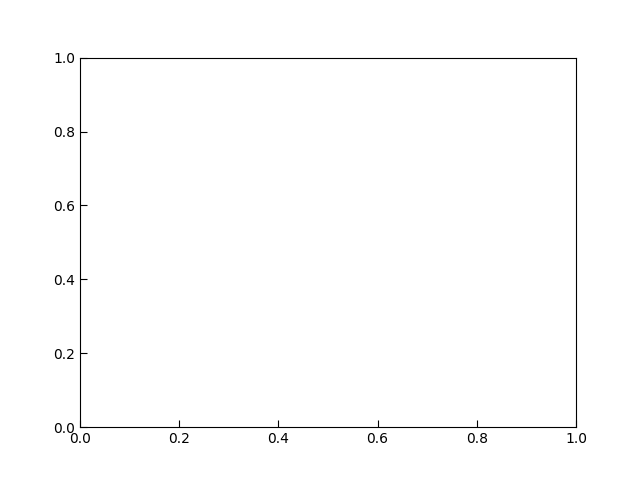

In [32]:

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

fig, ax = plt.subplots()
ax.plot(fits_arm1.x_tracing, fits_arm1.y_tracing, marker = 'o', label = 'Arm1')
ax.plot(fits_arm2.x_tracing, fits_arm2.y_tracing, marker = 'o', label = 'Arm2')
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.legend()
ax.set_aspect('equal')

In [86]:
def calc_euclidean(x1,y1,x2,y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [26]:
dist_previous = []
for i in range(len(df_tracing_arm2)):
    if i == 0:
        x1 = 0
        y1 = 0
        
        x2 = df_tracing_arm2.iloc[i].x
        y2 = df_tracing_arm2.iloc[i].y
        dist_previous.append(calc_euclidean(x1,y1,x2,y2))
        
    else:
        x1 = df_tracing_arm2.iloc[i-1].x
        y1 = df_tracing_arm2.iloc[i-1].y
        
        x2 = df_tracing_arm2.iloc[i].x
        y2 = df_tracing_arm2.iloc[i].y
        
        dist_previous.append(calc_euclidean(x1,y1,x2,y2))

NameError: name 'calc_euclidean' is not defined

In [27]:
df_tracing_arm2['dist_previous'] = dist_previous
df_tracing_arm2['arm_length'] = df_tracing_arm2.dist_previous.cumsum()

ValueError: Length of values does not match length of index

In [28]:
def assign_length(id_tracing, df_tracing):
    length = df_tracing[df_tracing.id == id_tracing].arm_length.values[0]
    return length

In [29]:
fits_arm2['arm_length'] = fits_arm2.apply(lambda row: assign_length(row.id_tracing, df_tracing_arm2), axis = 1)

NameError: name 'fits_arm2' is not defined

AttributeError: 'DataFrame' object has no attribute 'arm_length'

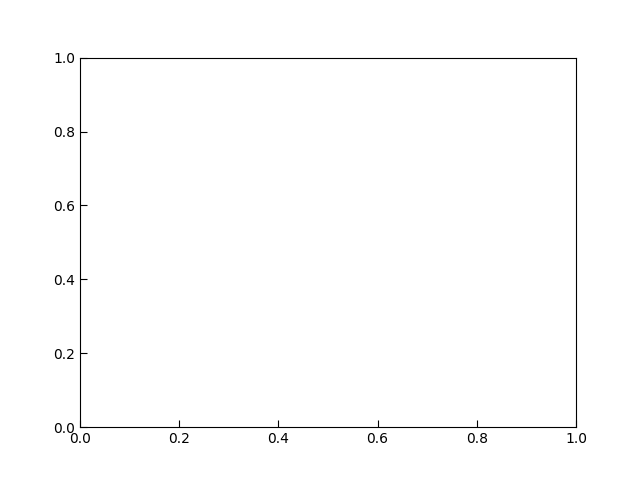

In [91]:
fig,ax = plt.subplots()
ax.scatter(fits_arm1.arm_length, fits_arm1.gamma)
ax.set_ylim(-1,1)

NameError: name 'arm1' is not defined

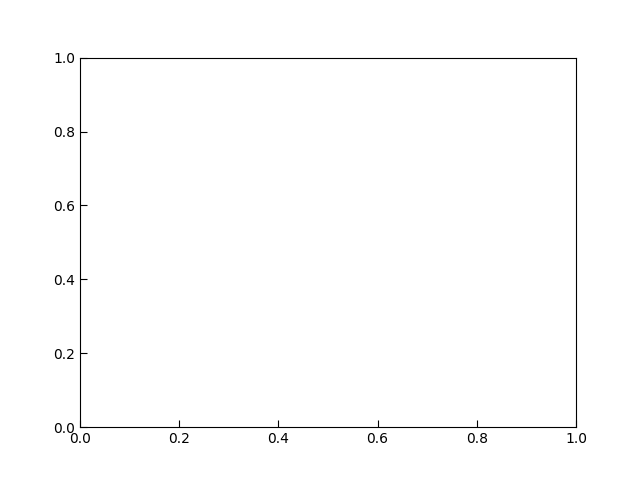

In [92]:
fig, ax = plt.subplots()
ax.plot(arm1.x_tracing, arm1.y_tracing)
ax.plot(arm2.x_tracing, arm2.y_tracing)
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.set_aspect('equal')

In [126]:
#df_fits.head
#print(df_fits["amplitude"], df_fits["center"], df_fits["sigma"],  df_fits["gamma"], df_fits["x_tracing"], df_fits["y_tracing"], df_fits["x_max"], df_fits["y_max"], df_fits["w1"], df_fits["w2"], df_fits["arm"], df_fits["fractured"])
#print(df_fits["w1"], df_fits["w2"])
#df_fits.to_csv('Arm_width_rho.csv')

In [127]:
df_print = pd.DataFrame(zip(df_fits.amplitude, df_fits.center, df_fits.sigma, df_fits.gamma, df_fits.x_tracing, df_fits.y_tracing, df_fits.x_max, df_fits.y_max, df_fits.w1, df_fits.w2, df_fits.arm, df_fits.fractured, df_fits.id_tracing))


In [128]:
df_print.to_csv('Arm2_widths_rho_adicionales_Ago4.csv')